In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd
import seaborn as sns
import re
from collections import Counter
import nltk
nltk.download('stopwords')
import pymorphy2
import pyLDAvis
import pyLDAvis.gensim
#import gensim
from tqdm import notebook
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksandralimkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
TOKEN_PATTERN = "[а-яА-ЯёЁa-zA-Z]+"

In [3]:
df = pd.read_csv('train.csv')

## Проанализируем исходные данные

In [4]:
df.head()

,ID,url,title,label
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",0
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,0
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,0
3,3,colorbox.spb.ru,Не Беси Меня Картинки,0
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,0


In [5]:
df.shape

(135309, 4)

<Axes: >

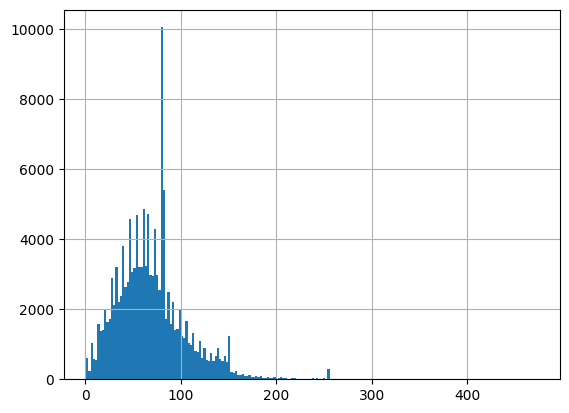

In [6]:
df.title.str.len().hist(bins=200)

Видим, что большинство тайтлов имеет длину от 0 до 200, однакл есть какие-то очень большие значения, которые встречаются редко, поэтому дропнем их

In [7]:
max_title_len = 150
df = df[df.title.str.len() <= max_title_len]
df.shape

(132315, 4)

<Axes: >

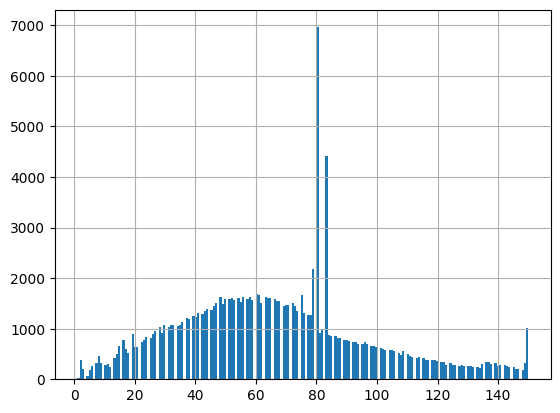

In [8]:
df.title.str.len().hist(bins=200)

<Axes: >

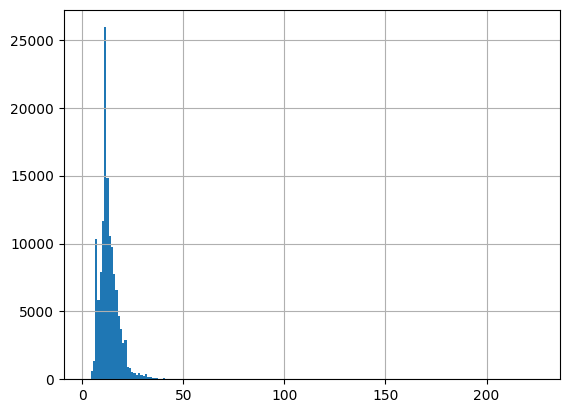

In [9]:
df.url.str.len().hist(bins=200)

Урлы имеют длину до 50. Также почистим выбросы

In [10]:
max_url_len = 30
df = df[df.url.str.len() <= max_url_len]
df.shape

(131014, 4)

<Axes: >

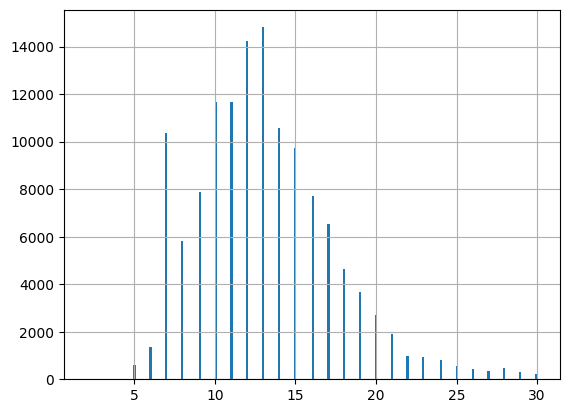

In [11]:
df.url.str.len().hist(bins=200)

Теперь объединим столбцы url и title в один

In [12]:
df['text'] = pd.concat([df['url'], df['title']], axis=1).apply(' '.join, axis=1)
df = df.drop(columns=['url', 'title'], axis=1)
df.head()

,ID,label,text
0,0,0,m.kp.md Экс-министр экономики Молдовы - главе ...
1,1,0,www.kp.by Эта песня стала известна многим теле...
2,2,0,fanserials.tv Банши 4 сезон 2 серия Бремя крас...
3,3,0,colorbox.spb.ru Не Беси Меня Картинки
4,4,0,tula-sport.ru В Новомосковске сыграют следж-хо...


In [13]:
df.shape

(131014, 3)

In [14]:
corpus = df.text.values
corpus[231]

'teleprogramma.pro Сергей Жорин: «Александр Толмацкий не собирается забирать ребенка у вдовы Децла!'

## Токенизация

In [15]:
def tokenize(text):
    return re.findall(TOKEN_PATTERN, text.lower())

In [16]:
texts = [tokenize(text) for text in corpus]

In [17]:
corpus

array(['m.kp.md Экс-министр экономики Молдовы - главе МИДЭИ, цель которого сделать из республики не просителя, а донора: Надо избегать долгого нахождения н�',
       'www.kp.by Эта песня стала известна многим телезрителям благодаря сериалу Диверсант-2',
       'fanserials.tv Банши 4 сезон 2 серия Бремя красоты смотреть онлайн!',
       ...,
       'topclassiccarsforsale.com 1941 Plymouth Special Deluxe Hot Rod, Automatic,Small Block,Power Steering, A/C for sale: photos, technical specifications, description',
       "wowcream.ru Купить It's Skin Сыворотка питательная Power 10 Formula YE Effector, 30 мл в Москве - WOWCREAM",
       'www.ubu.ru Технический спирт в канистрах и флаконах, купить в Москве'],
      dtype=object)

In [18]:
texts

[['m',
  'kp',
  'md',
  'экс',
  'министр',
  'экономики',
  'молдовы',
  'главе',
  'мидэи',
  'цель',
  'которого',
  'сделать',
  'из',
  'республики',
  'не',
  'просителя',
  'а',
  'донора',
  'надо',
  'избегать',
  'долгого',
  'нахождения',
  'н'],
 ['www',
  'kp',
  'by',
  'эта',
  'песня',
  'стала',
  'известна',
  'многим',
  'телезрителям',
  'благодаря',
  'сериалу',
  'диверсант'],
 ['fanserials',
  'tv',
  'банши',
  'сезон',
  'серия',
  'бремя',
  'красоты',
  'смотреть',
  'онлайн'],
 ['colorbox', 'spb', 'ru', 'не', 'беси', 'меня', 'картинки'],
 ['tula',
  'sport',
  'ru',
  'в',
  'новомосковске',
  'сыграют',
  'следж',
  'хоккеисты',
  'алексинской',
  'звезды',
  'и',
  'сборной',
  'китая',
  'т'],
 ['beregifiguru',
  'ru',
  'салат',
  'корейская',
  'морковь',
  'копченая',
  'курица',
  'кукуруза',
  'сухарики',
  'мой',
  'калорийность',
  'белки',
  'жиры',
  'углеводы'],
 ['ekb',
  'vseinstrumenti',
  'ru',
  'угловой',
  'пневмогайковерт',
  'fubag',
 

In [19]:
len(texts)

131014

## Распределение слов по частоте, стоп слова

In [20]:
occur = Counter([token for text in texts for token in text])

Количество уникальных токенов во всех текстах

In [21]:
len(occur)

180783

Посмотрим на первые 20 наиболее встречающихся токенов

In [22]:
occur.most_common(20)

[('ru', 87820),
 ('в', 35849),
 ('www', 24145),
 ('на', 21879),
 ('com', 21179),
 ('и', 20960),
 ('mail', 14630),
 ('онлайн', 11708),
 ('с', 10945),
 ('для', 9480),
 ('net', 8691),
 ('бесплатно', 7929),
 ('по', 7809),
 ('скачать', 7325),
 ('фото', 6180),
 ('страница', 5809),
 ('купить', 5740),
 ('ua', 5716),
 ('смотреть', 5470),
 ('поиск', 5277)]

Составим список служебных слов и доменов

In [23]:
stop_words_en = set(nltk.corpus.stopwords.words('english'))
stop_word_ru = set(nltk.corpus.stopwords.words('russian'))
stop_words_domains = set(['www', 'ru', 'ua', 'kz', 'com', 'net', 'mail', 'm', 'kp', 'md'])

stop_words = set(list(stop_words_en) + list(stop_word_ru) + list(stop_words_domains))

## Нормализация токенов

Отсортируем наши токены по алфавиту, чтобы посмотреть на формы слов

In [24]:
sorted_tokens = sorted(occur.keys())
sorted_tokens

['a',
 'aa',
 'aaa',
 'aaaaa',
 'aaaamhrfhdrb',
 'aaaauysnbekpmo',
 'aaabr',
 'aaacq',
 'aaag',
 'aaagl',
 'aaakvbf',
 'aaasb',
 'aabgjql',
 'aabsug',
 'aac',
 'aacbuczbw',
 'aacc',
 'aaceo',
 'aact',
 'aadc',
 'aadcijbu',
 'aadharhelp',
 'aadiddtob',
 'aadjlwktfy',
 'aae',
 'aaefabsd',
 'aaegnf',
 'aaen',
 'aaevnc',
 'aaexhibits',
 'aaf',
 'aafajh',
 'aafgbicfmhn',
 'aafge',
 'aafgh',
 'aafh',
 'aafwch',
 'aafy',
 'aafzjtdemb',
 'aagahqwyibe',
 'aagk',
 'aagmwjvmfo',
 'aagum',
 'aahd',
 'aahfjo',
 'aahgrctjf',
 'aahh',
 'aahhfbbnu',
 'aahjm',
 'aahuzqr',
 'aai',
 'aaiejoir',
 'aaiflkn',
 'aaivjfyj',
 'aaiwg',
 'aaj',
 'aaja',
 'aajgb',
 'aajgqkncdd',
 'aaka',
 'aakqthbd',
 'aal',
 'aaldd',
 'aalglgpbdfbw',
 'aalice',
 'aaliyah',
 'aalliyahh',
 'aalw',
 'aam',
 'aamir',
 'aan',
 'aanalhxjd',
 'aanhch',
 'aani',
 'aaoge',
 'aaokcpedrhrw',
 'aaoujwo',
 'aap',
 'aapkb',
 'aapqbh',
 'aapwp',
 'aaqa',
 'aarel',
 'aarin',
 'aarina',
 'aarjenitd',
 'aarы',
 'aas',
 'aasan',
 'aashiqui',
 'aas

Видим много мусора (непонятных слов), не будем трогать их, возможно, эти слова будут признаком "плохих сайтов"

In [25]:
lemmatizer = pymorphy2.MorphAnalyzer()

/opt/anaconda3/envs/work/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/opt/anaconda3/envs/work/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/opt/anaconda3/envs/work/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/opt/anaconda3/envs/work/lib/python3.10/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspe

напишем функцию, которая произведет лемматизацию и вернет словарь ключ - токен, значение - его нормальная форма

In [26]:
lemmatizer_cache = {}

def lemmatize(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

lemmatized_texts = [[lemmatize(token) for token in text] for text in (texts)]

cleared_texts = [[token for token in text if token not in stop_words] for text in lemmatized_texts]

In [27]:
occur_cleared = Counter([token for text in cleared_texts for token in text])

In [28]:
len(occur_cleared)

137751

In [29]:
occur_cleared

Counter({'онлайн': 11712,
         'бесплатно': 7929,
         'скачать': 7376,
         'поиск': 6358,
         'фото': 6180,
         'цена': 6146,
         'смотреть': 6094,
         'купить': 5943,
         'страница': 5897,
         'видео': 5008,
         'порно': 4932,
         'mp': 4259,
         'porn': 4230,
         'org': 4225,
         'результат': 4184,
         'год': 3974,
         'читать': 3627,
         'магазин': 3544,
         'отзыв': 3446,
         'работа': 3267,
         'olx': 3261,
         'москва': 3259,
         'интернет': 3143,
         'хороший': 3072,
         'online': 2879,
         'hd': 2773,
         'россия': 2759,
         'русский': 2750,
         'м': 2600,
         'мир': 2524,
         'info': 2464,
         'книга': 2444,
         'фильм': 2368,
         'sex': 2286,
         'сайт': 2249,
         'г': 2244,
         'video': 2233,
         'drom': 2209,
         'руб': 2192,
         'продажа': 2141,
         'tv': 2087,
         'ру': 2

In [30]:
cleared_texts

[['экс',
  'министр',
  'экономика',
  'молдова',
  'глава',
  'мидэи',
  'цель',
  'который',
  'сделать',
  'республика',
  'проситель',
  'донор',
  'избегать',
  'долгий',
  'нахождение',
  'н'],
 ['песня',
  'стать',
  'известный',
  'многий',
  'телезритель',
  'благодаря',
  'сериал',
  'диверсант'],
 ['fanserials',
  'tv',
  'банши',
  'сезон',
  'серия',
  'бремя',
  'красота',
  'смотреть',
  'онлайн'],
 ['colorbox', 'spb', 'бесить', 'картинка'],
 ['tula',
  'sport',
  'новомосковск',
  'сыграть',
  'следж',
  'хоккеист',
  'алексинский',
  'звезда',
  'сборная',
  'китай'],
 ['beregifiguru',
  'салат',
  'корейский',
  'морковь',
  'копчёный',
  'курица',
  'кукуруза',
  'сухарик',
  'калорийность',
  'белка',
  'жир',
  'углевод'],
 ['ekb',
  'vseinstrumenti',
  'угловой',
  'пневмогайковерт',
  'fubag',
  'rwc',
  'екатеринбург',
  'купить',
  'цена',
  'отзыв',
  'характеристика',
  'фото',
  'инструкция'],
 ['mirtabaka',
  'org',
  'табачный',
  'магазин',
  'мир',
  'та

Видим, что до леммитизации и чистки было 163306 уникальных слов, а после стало 118770

## TF-IDF

Преобразуем каждый текст в tf-idf вектор

In [31]:
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x, lowercase=False, max_df=0.7, min_df=1000, norm='l2'
).fit(cleared_texts)

/opt/anaconda3/envs/work/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Здесь мы обучили наш векторайзер, то есть нашли tf-idf вектор (длины 1 по l2 норме) для каждого текста.

Далее получии матрицу этих векторов

In [32]:
matrix = vectorizer.transform(cleared_texts).toarray()

Теперь посчитаем матрицу "похожести", она будет представлять собой матрицу косинусов каждого вектора с каждым. 
Искать будем как скалярное произведение каждого вектора с каждым (то есть матричное произведение матрицы векторов на
транспонированную матрицу). На длины не делим, так как длина всех векторов 1

In [33]:
s = 0
for i, el in enumerate(matrix[1]):
    s += el**2
s

1.0

Действительно 1, не обманул

Теперь напишем функцию, которая по матрице "похожести" вернет список кортежей, представляющих собой пару инлексов текстов и косинус между ними по заданному порогу

In [34]:
def sim_pairs(cos_sim, threshold):
    res = []
    for i in range(cos_sim.shape[0]):
        for j in range(cos_sim.shape[1]):
            if (i < j) and (cos_sim[i, j] >= threshold):
                res.append(((i ,j), cos_sim[i, j]))

## Counter Vectorizer

In [35]:
vectorizer = CountVectorizer(lowercase=False, tokenizer=lambda x: x, max_df=0.8, min_df=40).fit(cleared_texts)

In [36]:
matrix_cnt = vectorizer.transform(cleared_texts).toarray()

In [46]:
matrix_cnt.shape

(131014, 3766)

Подготовим данные для лог регрессии и обучим ее

In [47]:
X, y = pd.DataFrame(matrix_cnt), df.label

In [48]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,3756,3757,3758,3759,3760,3761,3762,3763,3764,3765
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [51]:
print(X_train.shape, y_train.shape)

(98260, 3766) (98260,)


In [ ]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
model_NB = MultinomialNB()
model_NB.fit(X_train, y_train)
y_pred_NB = model_NB.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_NB))

## Word2Vec

In [ ]:
word2vec = gensim.models.Word2Vec(sentences=cleared_texts, negative=20)

In [ ]:
word2vec.build_vocab(cleared_texts)

In [ ]:
word2vec.train(cleared_texts, total_examples=word2vec.corpus_count, epochs=30)

In [ ]:
word2vec.wv.most_similar('мама')

In [ ]:
word2vec

Загрузим тестовые данные и обработаем их

In [ ]:
df_test = pd.read_csv('test.csv')

In [ ]:
df_test.head()

In [ ]:
df_test['text'] = pd.concat([df_test['url'], df_test['title']], axis=1).apply(' '.join, axis=1)
df_test = df_test.drop(columns=['url', 'title'], axis=1)
df_test.head()

In [ ]:
corpus_test = df_test.text.values
corpus_test[231]

In [ ]:
texts_test = [tokenize(text) for text in corpus_test]

In [ ]:
lemmatized_texts_test = [[lemmatize(token) for token in text] for text in tqdm_notebook(texts_test)]

cleared_texts_test = [[token for token in text if token not in stop_words] for text in lemmatized_texts_test]

In [ ]:
vectorizer_test = CountVectorizer(lowercase=False, tokenizer=lambda x: x, max_df=0.8, min_df=40).fit(cleared_texts_test)

In [ ]:
matrix_cnt_test = vectorizer.transform(cleared_texts_test).toarray()

In [ ]:
matrix_cnt_test.shape

In [ ]:
X_global_test = pd.DataFrame(matrix_cnt_test)

In [ ]:
y_global_test = model_lr.predict(X_global_test)

In [ ]:
y_global_test

In [ ]:
ans = pd.DataFrame()

In [ ]:
ans['ID'] = df_test["ID"]
ans['label'] = y_global_test

In [ ]:
ans.to_csv('answer.csv', index=False)

# Вывод

В данном домашнем задании я реализовал модель машинного обучения, которая по тайтлу и урлу сайта определяет содержится ли там контент 18+. По итогу лучшая модель получилась та, которая использует технологию Word2Vec.